In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0
from tools.ae_v2 import Autoencoder
from tools.ESN_v1 import ESN
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-07-01 18:14:59.908284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.908541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.956024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.956564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.956939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.959230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 18:14:59.960218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.960650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 18:14:59.960925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# Lorenz System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_024'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/ESN_params_Search/params_search_003
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[      0 4200001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# ESN

In [24]:
# RNN data parameters
dt_rnn = 0.1
num_input_tsteps = 20000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [27]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

del(all_data)

In [28]:
print(data_rnn_input.shape)

(20, 20000, 2)


In [29]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 100
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 4

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        
        AR_testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        AR_testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  100


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (16, 20000, 2)
  training_data_rnn_output.shape :  (16, 20000, 2)
    testing_data_rnn_input.shape :  (2, 20000, 2)
   testing_data_rnn_output.shape :  (2, 20000, 2)
        val_data_rnn_input.shape :  (2, 20000, 2)
       val_data_rnn_output.shape :  (2, 20000, 2)

 AR_testing_data_rnn_input.shape :  (100, 11, 3)
AR_testing_data_rnn_output.shape :  (100, 44, 3)


In [35]:
val_loss_hist = []
train_loss_hist = []

In [36]:
training_data_rnn_input.dtype

dtype('float32')

In [37]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=num_latent_states,
        ESN=ESN,
        AR_RNN=AR_RNN,
        AR_AERNN=AR_AERNN,
        ae_net=ae_net,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        AR_RNN,
        AR_AERNN,
        ae_net,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input,
        T_sample_output,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [38]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-9, 1e-3, "log-uniform", "Real"], # lambda_reg
    [0.2, 1.2, "uniform", "Real"], # rho_res
    [0.5, 2.5, "uniform", "Real"], # omega_in
    [0.5, 1.0, "uniform", "Real"], # alpha
]
if vary_deg_connect == True:
    x_bounds.append([1, 10, "uniform", "Integer"])

In [39]:
h_dims = len(x_bounds)
# num_points = 10*h_dims
num_points = 50

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 5 ; num_points : 50 ; h_order : 2


In [40]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [41]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [42]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-09 2.00000000e-01 5.00000000e-01
  5.00000000e-01]
 [1.00000000e-03 1.00000000e-07 5.33333333e-01 5.00000000e-01
  6.66666667e-01]
 [1.00000000e-03 1.00000000e-07 2.00000000e-01 5.00000000e-01
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-09 5.33333333e-01 1.16666667e+00
  1.00000000e+00]
 [1.00000000e-03 1.00000000e-09 5.33333333e-01 1.83333333e+00
  1.00000000e+00]
 [1.00000000e-04 1.00000000e-07 2.00000000e-01 1.83333333e+00
  6.66666667e-01]
 [1.00000000e-04 1.00000000e-07 2.00000000e-01 2.50000000e+00
  5.00000000e-01]
 [1.00000000e-03 1.00000000e-09 8.66666667e-01 1.83333333e+00
  5.00000000e-01]
 [1.00000000e-04 1.00000000e-09 8.66666667e-01 2.50000000e+00
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-07 1.20000000e+00 1.83333333e+00
  8.33333333e-01]
 [1.00000000e-03 1.00000000e-09 8.66666667e-01 1.16666667e+00
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-07 8.66666667e-01 1.16666667e+00
  6.66666667e-01]
 [1.00000000e-03 1.00000000e-09 1.200000

In [43]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 10

In [44]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'rho_res_bounds':x_bounds[2],
    'omega_in_bounds':x_bounds[3],
    'alpha_bounds':x_bounds[4],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_deg_connect':vary_deg_connect,
}
if vary_deg_connect == True:
    optim_dict['deg_of_connectivity_bounds'] = x_bounds[5]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [45]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.43 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 9s
13 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 7s
14 / 16 -- Wout bat

6 / 16 -- batch_time : 2.229727029800415 sec
7 / 16 -- batch_time : 2.06722092628479 sec
8 / 16 -- batch_time : 2.087122678756714 sec
9 / 16 -- batch_time : 2.2698497772216797 sec
10 / 16 -- batch_time : 2.0834217071533203 sec
11 / 16 -- batch_time : 2.156852960586548 sec
12 / 16 -- batch_time : 2.198876142501831 sec
13 / 16 -- batch_time : 2.036949872970581 sec
14 / 16 -- batch_time : 2.1658263206481934 sec
15 / 16 -- batch_time : 2.2369279861450195 sec
16 / 16 -- batch_time : 2.104769706726074 sec

train_mse : 5.66862383948319e-05
val_mse : 6.640622450504452e-05
val_mse improved from inf

Total epoch computation time : 74.03386449813843 sec

test mse
1 / 2
2 / 2
test_mse : 8.130079731927253e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout ba

analysis time : 2.273312568664551 s

compute_time : 0h 6m 40s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 1.9651269912719727 sec
6 / 16 -- batch_time : 2.082094430923462 sec
7 / 16 -- batch_time : 2.019747734069824 sec
8 / 16 -- batch_time : 2.0327236652374268 sec
9 / 16 -- batch_time : 2.1439781188964844 sec
10 / 16 -- batch_time : 1.999504566192627 sec
11 / 16 -- batch_time : 2.1859652996063232 sec
12 / 16 -- batch_time : 2.0272397994995117 sec
13 / 16 -- batch_time : 2.2627804279327393 sec
14 / 16 -- batch_time : 2.204671859741211 sec
15 / 16 -- batch_time : 2.2383840084075928 sec
16 / 16 -- batch_time : 2.0518345832824707 sec

train_mse : 2.4339895162484023e-05
val_mse : 5.619872626994038e-05
val_mse improved from inf

Total epoch computation time : 72.23648238182068 sec

test mse
1 / 2
2 / 2
test_mse : 8.883409918780671e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.6327922344207764 s

compute_time : 0h 6m 31s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 32s
2 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 30s
3 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 23s
6 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.3216421604156494 sec
6 / 16 -- batch_time : 2.345015287399292 sec
7 / 16 -- batch_time : 2.3273096084594727 sec
8 / 16 -- batch_time : 2.2967824935913086 sec
9 / 16 -- batch_time : 2.3295235633850098 sec
10 / 16 -- batch_time : 2.2850699424743652 sec
11 / 16 -- batch_time : 2.07361102104187 sec
12 / 16 -- batch_time : 2.190009355545044 sec
13 / 16 -- batch_time : 2.2485766410827637 sec
14 / 16 -- batch_time : 2.1433095932006836 sec
15 / 16 -- batch_time : 2.4717178344726562 sec
16 / 16 -- batch_time : 2.170048475265503 sec

train_mse : 3.644639355115942e-05
val_mse : 4.547478965832852e-05
val_mse improved from inf

Total epoch computation time : 74.57773685455322 sec

test mse
1 / 2
2 / 2
test_mse : 5.0771866881405e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------------

analysis time : 2.604524612426758 s

compute_time : 0h 6m 30s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.00 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 1.9880924224853516 sec
6 / 16 -- batch_time : 2.0769851207733154 sec
7 / 16 -- batch_time : 2.104696035385132 sec
8 / 16 -- batch_time : 2.1462461948394775 sec
9 / 16 -- batch_time : 1.8777987957000732 sec
10 / 16 -- batch_time : 1.8389556407928467 sec
11 / 16 -- batch_time : 2.202716588973999 sec
12 / 16 -- batch_time : 2.098858594894409 sec
13 / 16 -- batch_time : 2.046727418899536 sec
14 / 16 -- batch_time : 1.9384956359863281 sec
15 / 16 -- batch_time : 2.096371650695801 sec
16 / 16 -- batch_time : 1.9877150058746338 sec

train_mse : 3.33087157287082e-05
val_mse : 4.565213203022722e-05
val_mse improved from inf

Total epoch computation time : 69.04204392433167 sec

test mse
1 / 2
2 / 2
test_mse : 4.663466279453132e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.3990190029144287 s

compute_time : 0h 6m 17s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 31s
2 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 30s
3 / 16 -- Wout batch_time : 2.00 s -- eta : 0h 0m 27s
4 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 25s
5 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 23s
6 / 16 -- Wout batch_time : 2.00 s -- eta : 0h 0m 21s
7 / 16 -- Wout batch_time : 1.99 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 1.95 s -- eta : 0h 0m 16s
9 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 14s
10 / 16 -- Wout batch_time : 1.93 s -- eta : 0h 0m 12s
11 / 16 -- Wout batch_time : 1.92 s -- eta : 0h 0m 10s
12 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 8s
13 / 16 --

5 / 16 -- batch_time : 1.8503139019012451 sec
6 / 16 -- batch_time : 2.028798818588257 sec
7 / 16 -- batch_time : 2.184516191482544 sec
8 / 16 -- batch_time : 2.085869550704956 sec
9 / 16 -- batch_time : 2.117342710494995 sec
10 / 16 -- batch_time : 1.9712576866149902 sec
11 / 16 -- batch_time : 2.0844788551330566 sec
12 / 16 -- batch_time : 1.9552314281463623 sec
13 / 16 -- batch_time : 1.8583731651306152 sec
14 / 16 -- batch_time : 1.9165327548980713 sec
15 / 16 -- batch_time : 2.008939027786255 sec
16 / 16 -- batch_time : 2.165199041366577 sec

train_mse : 4.16730084396022e-06
val_mse : 9.858746579993749e-06
val_mse improved from inf

Total epoch computation time : 70.05930542945862 sec

test mse
1 / 2
2 / 2
test_mse : 8.713349188838038e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------------

compute_time : 0h 6m 10s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 30s
3 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 27s
4 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.03 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 9s
13 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 

5 / 16 -- batch_time : 2.2729544639587402 sec
6 / 16 -- batch_time : 2.065967559814453 sec
7 / 16 -- batch_time : 2.010761260986328 sec
8 / 16 -- batch_time : 1.9567744731903076 sec
9 / 16 -- batch_time : 2.07377290725708 sec
10 / 16 -- batch_time : 2.0616018772125244 sec
11 / 16 -- batch_time : 2.317795991897583 sec
12 / 16 -- batch_time : 2.1770262718200684 sec
13 / 16 -- batch_time : 2.0413103103637695 sec
14 / 16 -- batch_time : 2.2687225341796875 sec
15 / 16 -- batch_time : 2.1277852058410645 sec
16 / 16 -- batch_time : 2.15946888923645 sec

train_mse : 4.2540455638118155e-06
val_mse : 2.341411914130731e-05
val_mse improved from inf

Total epoch computation time : 73.75048398971558 sec

test mse
1 / 2
2 / 2
test_mse : 1.8989741874975152e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.501364231109619 s

compute_time : 0h 6m 36s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.42 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.140782117843628 sec
6 / 16 -- batch_time : 2.2961440086364746 sec
7 / 16 -- batch_time : 2.1373515129089355 sec
8 / 16 -- batch_time : 2.163161277770996 sec
9 / 16 -- batch_time : 2.1741485595703125 sec
10 / 16 -- batch_time : 2.2400102615356445 sec
11 / 16 -- batch_time : 2.0687127113342285 sec
12 / 16 -- batch_time : 2.067516326904297 sec
13 / 16 -- batch_time : 2.2044379711151123 sec
14 / 16 -- batch_time : 2.2022578716278076 sec
15 / 16 -- batch_time : 2.1407041549682617 sec
16 / 16 -- batch_time : 2.142315626144409 sec

train_mse : 4.2316310384649106e-06
val_mse : 1.9647771750896936e-05
val_mse improved from inf

Total epoch computation time : 75.11353373527527 sec

test mse
1 / 2
2 / 2
test_mse : 1.261452712242317e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.543473482131958 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.51 s -- eta : 0h 0m 38s
2 / 16 -- Wout batch_time : 2.48 s -- eta : 0h 0m 35s
3 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 32s
4 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 29s
5 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 24s
7 / 16 -- Wout batch_time : 2.43 s -- eta : 0h 0m 22s
8 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.42 s -- eta : 0h 0m 17s
10 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.3645272254943848 sec
6 / 16 -- batch_time : 2.1055960655212402 sec
7 / 16 -- batch_time : 2.3933537006378174 sec
8 / 16 -- batch_time : 2.1858365535736084 sec
9 / 16 -- batch_time : 2.023482084274292 sec
10 / 16 -- batch_time : 2.193819522857666 sec
11 / 16 -- batch_time : 2.301624059677124 sec
12 / 16 -- batch_time : 2.1145079135894775 sec
13 / 16 -- batch_time : 2.107085943222046 sec
14 / 16 -- batch_time : 2.1299538612365723 sec
15 / 16 -- batch_time : 2.1461775302886963 sec
16 / 16 -- batch_time : 2.188030242919922 sec

train_mse : 2.3248598381542245e-05
val_mse : 2.9828009246557485e-05
val_mse improved from inf

Total epoch computation time : 75.35183763504028 sec

test mse
1 / 2
2 / 2
test_mse : 3.1083157409739215e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.8646888732910156 s

compute_time : 0h 6m 46s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.3000664710998535 sec
6 / 16 -- batch_time : 2.3109850883483887 sec
7 / 16 -- batch_time : 2.4046895503997803 sec
8 / 16 -- batch_time : 2.169578790664673 sec
9 / 16 -- batch_time : 2.322702169418335 sec
10 / 16 -- batch_time : 2.209217071533203 sec
11 / 16 -- batch_time : 2.3149585723876953 sec
12 / 16 -- batch_time : 2.3468143939971924 sec
13 / 16 -- batch_time : 2.342434883117676 sec
14 / 16 -- batch_time : 2.349369525909424 sec
15 / 16 -- batch_time : 2.3319242000579834 sec
16 / 16 -- batch_time : 2.414153575897217 sec

train_mse : 7.98002079704929e-06
val_mse : 9.102360309043434e-06
val_mse improved from inf

Total epoch computation time : 77.60208106040955 sec

test mse
1 / 2
2 / 2
test_mse : 1.6654315459163627e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.6172056198120117 s

compute_time : 0h 6m 47s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.45 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.233013868331909 sec
6 / 16 -- batch_time : 2.5057003498077393 sec
7 / 16 -- batch_time : 2.2155041694641113 sec
8 / 16 -- batch_time : 2.243407726287842 sec
9 / 16 -- batch_time : 2.1984992027282715 sec
10 / 16 -- batch_time : 2.2956132888793945 sec
11 / 16 -- batch_time : 2.295830488204956 sec
12 / 16 -- batch_time : 2.193077802658081 sec
13 / 16 -- batch_time : 2.466876983642578 sec
14 / 16 -- batch_time : 2.2522366046905518 sec
15 / 16 -- batch_time : 2.2520246505737305 sec
16 / 16 -- batch_time : 2.3238205909729004 sec

train_mse : 6.279341687331907e-05
val_mse : 6.18118756392505e-05
val_mse improved from inf

Total epoch computation time : 77.43759989738464 sec

test mse
1 / 2
2 / 2
test_mse : 6.363920692820102e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.595468044281006 s

compute_time : 0h 6m 44s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.54 s -- eta : 0h 0m 38s
2 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 34s
3 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.45 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.0548458099365234 sec
6 / 16 -- batch_time : 2.2546327114105225 sec
7 / 16 -- batch_time : 2.241346836090088 sec
8 / 16 -- batch_time : 1.9932584762573242 sec
9 / 16 -- batch_time : 2.144249677658081 sec
10 / 16 -- batch_time : 2.337566614151001 sec
11 / 16 -- batch_time : 2.2175638675689697 sec
12 / 16 -- batch_time : 2.203228712081909 sec
13 / 16 -- batch_time : 2.1439826488494873 sec
14 / 16 -- batch_time : 2.3652493953704834 sec
15 / 16 -- batch_time : 1.9586875438690186 sec
16 / 16 -- batch_time : 2.1440699100494385 sec

train_mse : 2.4706657200113114e-05
val_mse : 3.0349524422490504e-05
val_mse improved from inf

Total epoch computation time : 74.70848941802979 sec

test mse
1 / 2
2 / 2
test_mse : 3.5764505810220726e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------

analysis time : 2.689682722091675 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.52 s -- eta : 0h 0m 38s
2 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 1.994349718093872 sec
6 / 16 -- batch_time : 2.2581892013549805 sec
7 / 16 -- batch_time : 2.1906206607818604 sec
8 / 16 -- batch_time : 2.0039470195770264 sec
9 / 16 -- batch_time : 2.03572416305542 sec
10 / 16 -- batch_time : 2.155454397201538 sec
11 / 16 -- batch_time : 2.225853204727173 sec
12 / 16 -- batch_time : 2.125058889389038 sec
13 / 16 -- batch_time : 2.07338809967041 sec
14 / 16 -- batch_time : 2.2140796184539795 sec
15 / 16 -- batch_time : 2.010474443435669 sec
16 / 16 -- batch_time : 2.114410638809204 sec

train_mse : 2.811120077694795e-05
val_mse : 3.484067383396905e-05
val_mse improved from inf

Total epoch computation time : 73.1549940109253 sec

test mse
1 / 2
2 / 2
test_mse : 4.529836951405741e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------

compute_time : 0h 6m 39s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 9s
13 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 

6 / 16 -- batch_time : 2.268622636795044 sec
7 / 16 -- batch_time : 1.9887795448303223 sec
8 / 16 -- batch_time : 2.159625768661499 sec
9 / 16 -- batch_time : 2.1156482696533203 sec
10 / 16 -- batch_time : 2.192930221557617 sec
11 / 16 -- batch_time : 2.129999876022339 sec
12 / 16 -- batch_time : 2.1576764583587646 sec
13 / 16 -- batch_time : 2.1335079669952393 sec
14 / 16 -- batch_time : 1.9739196300506592 sec
15 / 16 -- batch_time : 2.3187901973724365 sec
16 / 16 -- batch_time : 2.240508556365967 sec

train_mse : 0.00022850445384392512
val_mse : 0.00022677899687550962
val_mse improved from inf

Total epoch computation time : 73.81766772270203 sec

test mse
1 / 2
2 / 2
test_mse : 0.00023221219453262165
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- 

analysis time : 2.6162540912628174 s

compute_time : 0h 6m 38s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.16933536529541 sec
6 / 16 -- batch_time : 2.254384756088257 sec
7 / 16 -- batch_time : 2.0535337924957275 sec
8 / 16 -- batch_time : 2.1444225311279297 sec
9 / 16 -- batch_time : 2.185573101043701 sec
10 / 16 -- batch_time : 2.220953941345215 sec
11 / 16 -- batch_time : 2.090153932571411 sec
12 / 16 -- batch_time : 2.2968714237213135 sec
13 / 16 -- batch_time : 2.1817996501922607 sec
14 / 16 -- batch_time : 2.1493921279907227 sec
15 / 16 -- batch_time : 2.1581664085388184 sec
16 / 16 -- batch_time : 2.0346717834472656 sec

train_mse : 0.0002766419002000476
val_mse : 0.00027618350577540696
val_mse improved from inf

Total epoch computation time : 74.38772463798523 sec

test mse
1 / 2
2 / 2
test_mse : 0.00028380658477544785
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.605306625366211 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.215029239654541 sec
6 / 16 -- batch_time : 2.173611640930176 sec
7 / 16 -- batch_time : 2.2929112911224365 sec
8 / 16 -- batch_time : 1.9510040283203125 sec
9 / 16 -- batch_time : 2.2150676250457764 sec
10 / 16 -- batch_time : 2.243443012237549 sec
11 / 16 -- batch_time : 2.1199967861175537 sec
12 / 16 -- batch_time : 2.110874652862549 sec
13 / 16 -- batch_time : 2.1263086795806885 sec
14 / 16 -- batch_time : 2.0741066932678223 sec
15 / 16 -- batch_time : 2.168602228164673 sec
16 / 16 -- batch_time : 2.040534257888794 sec

train_mse : 3.0251112889345677e-05
val_mse : 3.836853920802241e-05
val_mse improved from inf

Total epoch computation time : 74.32415819168091 sec

test mse
1 / 2
2 / 2
test_mse : 4.990003344573779e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.7832932472229004 s

compute_time : 0h 6m 43s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.42 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.53 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.465040445327759 sec
6 / 16 -- batch_time : 2.2587337493896484 sec
7 / 16 -- batch_time : 2.280305862426758 sec
8 / 16 -- batch_time : 2.2814829349517822 sec
9 / 16 -- batch_time : 2.3636813163757324 sec
10 / 16 -- batch_time : 2.364612340927124 sec
11 / 16 -- batch_time : 2.3529179096221924 sec
12 / 16 -- batch_time : 2.4588398933410645 sec
13 / 16 -- batch_time : 2.3404808044433594 sec
14 / 16 -- batch_time : 2.2693281173706055 sec
15 / 16 -- batch_time : 2.300945520401001 sec
16 / 16 -- batch_time : 2.12148380279541 sec

train_mse : 3.2651970741426346e-05
val_mse : 3.558724529284518e-05
val_mse improved from inf

Total epoch computation time : 78.84824895858765 sec

test mse
1 / 2
2 / 2
test_mse : 4.46228059445275e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.674635648727417 s

compute_time : 0h 7m 4s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.45 s -- eta : 0h 0m 24s
7 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 9s
13 / 16 -- W

5 / 16 -- batch_time : 2.1946098804473877 sec
6 / 16 -- batch_time : 2.4245944023132324 sec
7 / 16 -- batch_time : 2.1684203147888184 sec
8 / 16 -- batch_time : 2.099191904067993 sec
9 / 16 -- batch_time : 2.10961651802063 sec
10 / 16 -- batch_time : 2.2966558933258057 sec
11 / 16 -- batch_time : 2.264179229736328 sec
12 / 16 -- batch_time : 2.1095478534698486 sec
13 / 16 -- batch_time : 1.9957311153411865 sec
14 / 16 -- batch_time : 2.0446462631225586 sec
15 / 16 -- batch_time : 2.0817723274230957 sec
16 / 16 -- batch_time : 2.322798490524292 sec

train_mse : 6.728303014824634e-05
val_mse : 6.68485154164955e-05
val_mse improved from inf

Total epoch computation time : 75.63499307632446 sec

test mse
1 / 2
2 / 2
test_mse : 6.766296428395435e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.561845302581787 s

compute_time : 0h 6m 46s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.211669921875 sec
6 / 16 -- batch_time : 2.12327241897583 sec
7 / 16 -- batch_time : 2.2026145458221436 sec
8 / 16 -- batch_time : 2.1214497089385986 sec
9 / 16 -- batch_time : 2.2438817024230957 sec
10 / 16 -- batch_time : 2.0749175548553467 sec
11 / 16 -- batch_time : 2.303832530975342 sec
12 / 16 -- batch_time : 2.1110713481903076 sec
13 / 16 -- batch_time : 2.123870849609375 sec
14 / 16 -- batch_time : 2.161219596862793 sec
15 / 16 -- batch_time : 2.276022434234619 sec
16 / 16 -- batch_time : 2.0122323036193848 sec

train_mse : 8.326758404564318e-06
val_mse : 8.726527994440403e-06
val_mse improved from inf

Total epoch computation time : 74.41526341438293 sec

test mse
1 / 2
2 / 2
test_mse : 1.416597660863772e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------------

analysis time : 2.493985652923584 s

compute_time : 0h 6m 39s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.2949819564819336 sec
6 / 16 -- batch_time : 2.1747634410858154 sec
7 / 16 -- batch_time : 2.3176209926605225 sec
8 / 16 -- batch_time : 2.2624568939208984 sec
9 / 16 -- batch_time : 2.111271858215332 sec
10 / 16 -- batch_time : 2.2843921184539795 sec
11 / 16 -- batch_time : 2.109163761138916 sec
12 / 16 -- batch_time : 2.2188334465026855 sec
13 / 16 -- batch_time : 2.1653971672058105 sec
14 / 16 -- batch_time : 2.099200487136841 sec
15 / 16 -- batch_time : 2.226041078567505 sec
16 / 16 -- batch_time : 2.053041696548462 sec

train_mse : 3.0444435310528196e-05
val_mse : 3.5906701668864116e-05
val_mse improved from inf

Total epoch computation time : 75.73409867286682 sec

test mse
1 / 2
2 / 2
test_mse : 4.017803985334467e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.6319329738616943 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.45 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.1902198791503906 sec
6 / 16 -- batch_time : 2.1623146533966064 sec
7 / 16 -- batch_time : 2.0419833660125732 sec
8 / 16 -- batch_time : 2.1634204387664795 sec
9 / 16 -- batch_time : 2.136467933654785 sec
10 / 16 -- batch_time : 2.160815954208374 sec
11 / 16 -- batch_time : 2.064059257507324 sec
12 / 16 -- batch_time : 2.3046278953552246 sec
13 / 16 -- batch_time : 2.150862216949463 sec
14 / 16 -- batch_time : 2.2020938396453857 sec
15 / 16 -- batch_time : 2.0543103218078613 sec
16 / 16 -- batch_time : 2.007380485534668 sec

train_mse : 8.97400184385333e-06
val_mse : 1.553977381263394e-05
val_mse improved from inf

Total epoch computation time : 73.90861654281616 sec

test mse
1 / 2
2 / 2
test_mse : 1.4700952306156978e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.649033308029175 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.265199899673462 sec
6 / 16 -- batch_time : 2.2739384174346924 sec
7 / 16 -- batch_time : 2.276818037033081 sec
8 / 16 -- batch_time : 2.125504493713379 sec
9 / 16 -- batch_time : 2.12491774559021 sec
10 / 16 -- batch_time : 2.050365686416626 sec
11 / 16 -- batch_time : 2.1893224716186523 sec
12 / 16 -- batch_time : 2.1519150733947754 sec
13 / 16 -- batch_time : 2.1670680046081543 sec
14 / 16 -- batch_time : 2.0558345317840576 sec
15 / 16 -- batch_time : 2.102693557739258 sec
16 / 16 -- batch_time : 2.2147748470306396 sec

train_mse : 1.1939562625684632e-05
val_mse : 1.6673399386490928e-05
val_mse improved from inf

Total epoch computation time : 74.45565581321716 sec

test mse
1 / 2
2 / 2
test_mse : 2.1763225504400907e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.314863920211792 s

compute_time : 0h 6m 40s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.05 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.03 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.02 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.075702428817749 sec
6 / 16 -- batch_time : 2.0465471744537354 sec
7 / 16 -- batch_time : 2.05505633354187 sec
8 / 16 -- batch_time : 2.2264599800109863 sec
9 / 16 -- batch_time : 1.9630439281463623 sec
10 / 16 -- batch_time : 2.211866855621338 sec
11 / 16 -- batch_time : 2.067735433578491 sec
12 / 16 -- batch_time : 2.1404521465301514 sec
13 / 16 -- batch_time : 1.9042115211486816 sec
14 / 16 -- batch_time : 2.0471653938293457 sec
15 / 16 -- batch_time : 2.073704957962036 sec
16 / 16 -- batch_time : 1.9604721069335938 sec

train_mse : 9.545977491143274e-06
val_mse : 1.057251165548223e-05
val_mse improved from inf

Total epoch computation time : 71.7743558883667 sec

test mse
1 / 2
2 / 2
test_mse : 1.5794296359672444e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.4153053760528564 s

compute_time : 0h 6m 23s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 32s
2 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 30s
3 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.05 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.02 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.0754711627960205 sec
6 / 16 -- batch_time : 2.1862239837646484 sec
7 / 16 -- batch_time : 2.2050628662109375 sec
8 / 16 -- batch_time : 2.081437826156616 sec
9 / 16 -- batch_time : 1.988330602645874 sec
10 / 16 -- batch_time : 1.9818663597106934 sec
11 / 16 -- batch_time : 1.9390110969543457 sec
12 / 16 -- batch_time : 2.07985782623291 sec
13 / 16 -- batch_time : 2.027061700820923 sec
14 / 16 -- batch_time : 2.1505589485168457 sec
15 / 16 -- batch_time : 2.096104860305786 sec
16 / 16 -- batch_time : 2.1897389888763428 sec

train_mse : 1.0469781955180222e-05
val_mse : 1.5708155387983425e-05
val_mse improved from inf

Total epoch computation time : 71.74479413032532 sec

test mse
1 / 2
2 / 2
test_mse : 2.1405648112704512e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.467404365539551 s

compute_time : 0h 6m 21s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.0748884677886963 sec
6 / 16 -- batch_time : 2.107121229171753 sec
7 / 16 -- batch_time : 2.2197887897491455 sec
8 / 16 -- batch_time : 2.2067980766296387 sec
9 / 16 -- batch_time : 2.270334482192993 sec
10 / 16 -- batch_time : 2.338078022003174 sec
11 / 16 -- batch_time : 2.2111942768096924 sec
12 / 16 -- batch_time : 2.1763129234313965 sec
13 / 16 -- batch_time : 2.087386131286621 sec
14 / 16 -- batch_time : 2.250692367553711 sec
15 / 16 -- batch_time : 2.242992401123047 sec
16 / 16 -- batch_time : 2.3068413734436035 sec

train_mse : 0.00019142822657158834
val_mse : 0.00019046973466174677
val_mse improved from inf

Total epoch computation time : 74.99535703659058 sec

test mse
1 / 2
2 / 2
test_mse : 0.00018976569845108315
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.618576765060425 s

compute_time : 0h 6m 40s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.131894826889038 sec
6 / 16 -- batch_time : 2.279311418533325 sec
7 / 16 -- batch_time : 2.0147268772125244 sec
8 / 16 -- batch_time : 2.133557081222534 sec
9 / 16 -- batch_time : 2.0771143436431885 sec
10 / 16 -- batch_time : 2.14760160446167 sec
11 / 16 -- batch_time : 2.2151737213134766 sec
12 / 16 -- batch_time : 2.0656189918518066 sec
13 / 16 -- batch_time : 2.221555471420288 sec
14 / 16 -- batch_time : 2.0923755168914795 sec
15 / 16 -- batch_time : 2.1636428833007812 sec
16 / 16 -- batch_time : 2.186105251312256 sec

train_mse : 0.00012980246447114036
val_mse : 0.00013266292808111757
val_mse improved from inf

Total epoch computation time : 73.47190856933594 sec

test mse
1 / 2
2 / 2
test_mse : 0.00012843572767451406
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.501920223236084 s

compute_time : 0h 6m 36s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.196239471435547 sec
6 / 16 -- batch_time : 2.2216556072235107 sec
7 / 16 -- batch_time : 2.2027108669281006 sec
8 / 16 -- batch_time : 2.192556381225586 sec
9 / 16 -- batch_time : 2.174790382385254 sec
10 / 16 -- batch_time : 2.1375174522399902 sec
11 / 16 -- batch_time : 2.207069158554077 sec
12 / 16 -- batch_time : 2.282696485519409 sec
13 / 16 -- batch_time : 2.2382254600524902 sec
14 / 16 -- batch_time : 2.057081937789917 sec
15 / 16 -- batch_time : 2.1379218101501465 sec
16 / 16 -- batch_time : 2.0301260948181152 sec

train_mse : 0.00014034273408469747
val_mse : 0.00014228783402359113
val_mse improved from inf

Total epoch computation time : 73.78252053260803 sec

test mse
1 / 2
2 / 2
test_mse : 0.0001403425121679902
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.5413498878479004 s

compute_time : 0h 6m 35s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.111905097961426 sec
6 / 16 -- batch_time : 2.1535773277282715 sec
7 / 16 -- batch_time : 2.2034521102905273 sec
8 / 16 -- batch_time : 2.1589200496673584 sec
9 / 16 -- batch_time : 2.190826654434204 sec
10 / 16 -- batch_time : 2.037642478942871 sec
11 / 16 -- batch_time : 2.261378288269043 sec
12 / 16 -- batch_time : 2.0860416889190674 sec
13 / 16 -- batch_time : 2.0480973720550537 sec
14 / 16 -- batch_time : 2.2430663108825684 sec
15 / 16 -- batch_time : 2.341902017593384 sec
16 / 16 -- batch_time : 2.2367773056030273 sec

train_mse : 0.0002847646846930729
val_mse : 0.0002835022023646161
val_mse improved from inf

Total epoch computation time : 75.53267502784729 sec

test mse
1 / 2
2 / 2
test_mse : 0.0002851556637324393
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.494502067565918 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.47 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.300102949142456 sec
6 / 16 -- batch_time : 2.1893460750579834 sec
7 / 16 -- batch_time : 2.174184560775757 sec
8 / 16 -- batch_time : 2.0817010402679443 sec
9 / 16 -- batch_time : 2.1697335243225098 sec
10 / 16 -- batch_time : 2.0838565826416016 sec
11 / 16 -- batch_time : 2.0332889556884766 sec
12 / 16 -- batch_time : 2.0667922496795654 sec
13 / 16 -- batch_time : 2.0765485763549805 sec
14 / 16 -- batch_time : 2.1817362308502197 sec
15 / 16 -- batch_time : 2.071683645248413 sec
16 / 16 -- batch_time : 2.1434693336486816 sec

train_mse : 0.0003803545168921119
val_mse : 0.0003788393223658204
val_mse improved from inf

Total epoch computation time : 74.1895534992218 sec

test mse
1 / 2
2 / 2
test_mse : 0.0003813445946434513
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.4770171642303467 s

compute_time : 0h 6m 40s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.03 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 1.98 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 1.9586224555969238 sec
6 / 16 -- batch_time : 2.013856887817383 sec
7 / 16 -- batch_time : 2.1205334663391113 sec
8 / 16 -- batch_time : 2.043832540512085 sec
9 / 16 -- batch_time : 2.063565969467163 sec
10 / 16 -- batch_time : 2.064035177230835 sec
11 / 16 -- batch_time : 2.1403181552886963 sec
12 / 16 -- batch_time : 2.0651626586914062 sec
13 / 16 -- batch_time : 2.1003963947296143 sec
14 / 16 -- batch_time : 2.1748344898223877 sec
15 / 16 -- batch_time : 1.9422245025634766 sec
16 / 16 -- batch_time : 2.020420789718628 sec

train_mse : 2.2734663389201156e-05
val_mse : 2.3699997655057814e-05
val_mse improved from inf

Total epoch computation time : 70.55480027198792 sec

test mse
1 / 2
2 / 2
test_mse : 2.378162753302604e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.514033079147339 s

compute_time : 0h 6m 21s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.06 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.03 s -- eta : 0h 0m 25s
5 / 16 -- Wout batch_time : 2.06 s -- eta : 0h 0m 23s
6 / 16 -- Wout batch_time : 2.01 s -- eta : 0h 0m 21s
7 / 16 -- Wout batch_time : 2.02 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.00 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 8s
13 / 16 -- 

5 / 16 -- batch_time : 2.0535759925842285 sec
6 / 16 -- batch_time : 2.1081411838531494 sec
7 / 16 -- batch_time : 2.1215736865997314 sec
8 / 16 -- batch_time : 1.9974961280822754 sec
9 / 16 -- batch_time : 2.0764048099517822 sec
10 / 16 -- batch_time : 1.9938733577728271 sec
11 / 16 -- batch_time : 1.9144337177276611 sec
12 / 16 -- batch_time : 2.0484166145324707 sec
13 / 16 -- batch_time : 2.0954785346984863 sec
14 / 16 -- batch_time : 2.0855934619903564 sec
15 / 16 -- batch_time : 2.1217823028564453 sec
16 / 16 -- batch_time : 2.065626382827759 sec

train_mse : 1.888671113192686e-05
val_mse : 1.9111985238851048e-05
val_mse improved from inf

Total epoch computation time : 71.42009687423706 sec

test mse
1 / 2
2 / 2
test_mse : 2.064993532258086e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------

analysis time : 2.4267444610595703 s

compute_time : 0h 6m 25s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.195707321166992 sec
6 / 16 -- batch_time : 2.1170122623443604 sec
7 / 16 -- batch_time : 2.1075267791748047 sec
8 / 16 -- batch_time : 2.0879464149475098 sec
9 / 16 -- batch_time : 2.1450092792510986 sec
10 / 16 -- batch_time : 2.2172510623931885 sec
11 / 16 -- batch_time : 2.3444180488586426 sec
12 / 16 -- batch_time : 2.123080015182495 sec
13 / 16 -- batch_time : 2.2761340141296387 sec
14 / 16 -- batch_time : 2.0270631313323975 sec
15 / 16 -- batch_time : 2.1175687313079834 sec
16 / 16 -- batch_time : 2.206453561782837 sec

train_mse : 8.671517798575223e-05
val_mse : 8.688880188856274e-05
val_mse improved from inf

Total epoch computation time : 75.3697099685669 sec

test mse
1 / 2
2 / 2
test_mse : 8.796168913249858e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.461634635925293 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.43 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.07 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.205702066421509 sec
6 / 16 -- batch_time : 2.431518316268921 sec
7 / 16 -- batch_time : 2.105537176132202 sec
8 / 16 -- batch_time : 2.229790210723877 sec
9 / 16 -- batch_time : 2.0924410820007324 sec
10 / 16 -- batch_time : 2.1561622619628906 sec
11 / 16 -- batch_time : 2.221656084060669 sec
12 / 16 -- batch_time : 2.1417386531829834 sec
13 / 16 -- batch_time : 2.100724220275879 sec
14 / 16 -- batch_time : 2.1649365425109863 sec
15 / 16 -- batch_time : 2.1699142456054688 sec
16 / 16 -- batch_time : 2.2237889766693115 sec

train_mse : 6.0894111584275386e-05
val_mse : 6.212935477378778e-05
val_mse improved from inf

Total epoch computation time : 74.60999965667725 sec

test mse
1 / 2
2 / 2
test_mse : 6.165498780319467e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.2829740047454834 s

compute_time : 0h 6m 44s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.44 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.1496424674987793 sec
6 / 16 -- batch_time : 2.092621088027954 sec
7 / 16 -- batch_time : 2.332498788833618 sec
8 / 16 -- batch_time : 2.044464349746704 sec
9 / 16 -- batch_time : 2.274648666381836 sec
10 / 16 -- batch_time : 2.16241192817688 sec
11 / 16 -- batch_time : 2.0235397815704346 sec
12 / 16 -- batch_time : 2.053633213043213 sec
13 / 16 -- batch_time : 2.1565566062927246 sec
14 / 16 -- batch_time : 2.268887519836426 sec
15 / 16 -- batch_time : 2.1564230918884277 sec
16 / 16 -- batch_time : 2.1545937061309814 sec

train_mse : 3.9474455661547836e-05
val_mse : 4.187742706562858e-05
val_mse improved from inf

Total epoch computation time : 75.46105313301086 sec

test mse
1 / 2
2 / 2
test_mse : 4.239384725224227e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------------

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 9s
13 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 

5 / 16 -- batch_time : 2.2117974758148193 sec
6 / 16 -- batch_time : 2.100947380065918 sec
7 / 16 -- batch_time : 2.1169145107269287 sec
8 / 16 -- batch_time : 2.2378878593444824 sec
9 / 16 -- batch_time : 2.37241268157959 sec
10 / 16 -- batch_time : 2.2261743545532227 sec
11 / 16 -- batch_time : 2.053287982940674 sec
12 / 16 -- batch_time : 2.3451035022735596 sec
13 / 16 -- batch_time : 2.3325302600860596 sec
14 / 16 -- batch_time : 2.2850887775421143 sec
15 / 16 -- batch_time : 2.0560460090637207 sec
16 / 16 -- batch_time : 2.0722227096557617 sec

train_mse : 1.647570536533749e-05
val_mse : 1.7201254195242655e-05
val_mse improved from inf

Total epoch computation time : 74.95114731788635 sec

test mse
1 / 2
2 / 2
test_mse : 1.7301922525803093e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.393585443496704 s

compute_time : 0h 6m 40s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.1801605224609375 sec
6 / 16 -- batch_time : 2.2019100189208984 sec
7 / 16 -- batch_time : 2.063868761062622 sec
8 / 16 -- batch_time : 2.3142874240875244 sec
9 / 16 -- batch_time : 2.087806224822998 sec
10 / 16 -- batch_time : 2.3948357105255127 sec
11 / 16 -- batch_time : 2.1328861713409424 sec
12 / 16 -- batch_time : 2.1105270385742188 sec
13 / 16 -- batch_time : 2.123074531555176 sec
14 / 16 -- batch_time : 2.1457762718200684 sec
15 / 16 -- batch_time : 2.184446334838867 sec
16 / 16 -- batch_time : 2.042799949645996 sec

train_mse : 0.00019997305480501382
val_mse : 0.00020060083625139669
val_mse improved from inf

Total epoch computation time : 74.76351642608643 sec

test mse
1 / 2
2 / 2
test_mse : 0.0002033142591244541
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.6126387119293213 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.2833542823791504 sec
6 / 16 -- batch_time : 2.2680792808532715 sec
7 / 16 -- batch_time : 2.1892337799072266 sec
8 / 16 -- batch_time : 2.3239195346832275 sec
9 / 16 -- batch_time : 2.076540946960449 sec
10 / 16 -- batch_time : 2.1725964546203613 sec
11 / 16 -- batch_time : 2.089797019958496 sec
12 / 16 -- batch_time : 2.206995725631714 sec
13 / 16 -- batch_time : 2.137871503829956 sec
14 / 16 -- batch_time : 2.112051248550415 sec
15 / 16 -- batch_time : 2.029413938522339 sec
16 / 16 -- batch_time : 2.2719244956970215 sec

train_mse : 4.4536259565575165e-05
val_mse : 4.46415288024582e-05
val_mse improved from inf

Total epoch computation time : 74.45851016044617 sec

test mse
1 / 2
2 / 2
test_mse : 4.603708293871023e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.469884157180786 s

compute_time : 0h 6m 38s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.44 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.46 s -- eta : 0h 0m 34s
3 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 29s
5 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 24s
7 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.1777381896972656 sec
6 / 16 -- batch_time : 2.4291090965270996 sec
7 / 16 -- batch_time : 2.480755567550659 sec
8 / 16 -- batch_time : 2.4171881675720215 sec
9 / 16 -- batch_time : 2.366570472717285 sec
10 / 16 -- batch_time : 2.3062796592712402 sec
11 / 16 -- batch_time : 2.317335367202759 sec
12 / 16 -- batch_time : 2.284714460372925 sec
13 / 16 -- batch_time : 2.353182315826416 sec
14 / 16 -- batch_time : 2.3105006217956543 sec
15 / 16 -- batch_time : 2.4112415313720703 sec
16 / 16 -- batch_time : 2.354670286178589 sec

train_mse : 0.00017209056841238635
val_mse : 0.00017278560699196532
val_mse improved from inf

Total epoch computation time : 78.38245391845703 sec

test mse
1 / 2
2 / 2
test_mse : 0.0001740181614877656
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.7457175254821777 s

compute_time : 0h 6m 53s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.1645164489746094 sec
6 / 16 -- batch_time : 2.0488829612731934 sec
7 / 16 -- batch_time : 2.0962445735931396 sec
8 / 16 -- batch_time : 2.284076452255249 sec
9 / 16 -- batch_time : 2.0957424640655518 sec
10 / 16 -- batch_time : 2.1661486625671387 sec
11 / 16 -- batch_time : 2.091092586517334 sec
12 / 16 -- batch_time : 2.0285089015960693 sec
13 / 16 -- batch_time : 2.2116401195526123 sec
14 / 16 -- batch_time : 2.1514101028442383 sec
15 / 16 -- batch_time : 2.200542688369751 sec
16 / 16 -- batch_time : 2.1117992401123047 sec

train_mse : 0.0002788321380648994
val_mse : 0.0002782992960419506
val_mse improved from inf

Total epoch computation time : 75.62042307853699 sec

test mse
1 / 2
2 / 2
test_mse : 0.0002856706123566255
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------------------------------------------------

analysis time : 2.583185911178589 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.50 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.0123565196990967 sec
6 / 16 -- batch_time : 2.2701990604400635 sec
7 / 16 -- batch_time : 2.058539867401123 sec
8 / 16 -- batch_time : 2.0731801986694336 sec
9 / 16 -- batch_time : 2.386436700820923 sec
10 / 16 -- batch_time : 2.1693270206451416 sec
11 / 16 -- batch_time : 2.2461986541748047 sec
12 / 16 -- batch_time : 2.095792770385742 sec
13 / 16 -- batch_time : 2.076324224472046 sec
14 / 16 -- batch_time : 2.187680721282959 sec
15 / 16 -- batch_time : 2.078667640686035 sec
16 / 16 -- batch_time : 2.08634614944458 sec

train_mse : 0.0002359609916311456
val_mse : 0.00023530855105491355
val_mse improved from inf

Total epoch computation time : 74.37387776374817 sec

test mse
1 / 2
2 / 2
test_mse : 0.00024077994748950005
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.6184442043304443 s

compute_time : 0h 6m 38s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 21s
7 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 19s
8 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.074033737182617 sec
6 / 16 -- batch_time : 2.3159477710723877 sec
7 / 16 -- batch_time : 2.2704806327819824 sec
8 / 16 -- batch_time : 2.0564048290252686 sec
9 / 16 -- batch_time : 2.3381311893463135 sec
10 / 16 -- batch_time : 2.121290683746338 sec
11 / 16 -- batch_time : 2.1639175415039062 sec
12 / 16 -- batch_time : 2.1339473724365234 sec
13 / 16 -- batch_time : 2.197154998779297 sec
14 / 16 -- batch_time : 2.2841286659240723 sec
15 / 16 -- batch_time : 2.229226589202881 sec
16 / 16 -- batch_time : 2.167593240737915 sec

train_mse : 0.00016676780796842655
val_mse : 0.00016746975597925484
val_mse improved from inf

Total epoch computation time : 74.74169898033142 sec

test mse
1 / 2
2 / 2
test_mse : 0.00016890848928596824
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.392548084259033 s

compute_time : 0h 6m 35s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.47 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.42 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.39 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.1589457988739014 sec
6 / 16 -- batch_time : 2.268651008605957 sec
7 / 16 -- batch_time : 2.1135003566741943 sec
8 / 16 -- batch_time : 2.300964593887329 sec
9 / 16 -- batch_time : 2.1911368370056152 sec
10 / 16 -- batch_time : 2.4040493965148926 sec
11 / 16 -- batch_time : 2.385979413986206 sec
12 / 16 -- batch_time : 2.380857229232788 sec
13 / 16 -- batch_time : 2.2159831523895264 sec
14 / 16 -- batch_time : 2.328050374984741 sec
15 / 16 -- batch_time : 2.18343186378479 sec
16 / 16 -- batch_time : 2.387427568435669 sec

train_mse : 3.6910977541992906e-05
val_mse : 3.7052290281280875e-05
val_mse improved from inf

Total epoch computation time : 77.16662168502808 sec

test mse
1 / 2
2 / 2
test_mse : 3.914683111361228e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.5319159030914307 s

compute_time : 0h 6m 44s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 30s
3 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.1332101821899414 sec
6 / 16 -- batch_time : 2.3176686763763428 sec
7 / 16 -- batch_time : 2.021095037460327 sec
8 / 16 -- batch_time : 2.0151455402374268 sec
9 / 16 -- batch_time : 2.065680742263794 sec
10 / 16 -- batch_time : 2.253338575363159 sec
11 / 16 -- batch_time : 2.0874950885772705 sec
12 / 16 -- batch_time : 2.202395439147949 sec
13 / 16 -- batch_time : 2.137847900390625 sec
14 / 16 -- batch_time : 2.109971761703491 sec
15 / 16 -- batch_time : 2.0769715309143066 sec
16 / 16 -- batch_time : 2.251532554626465 sec

train_mse : 0.0001830835808505071
val_mse : 0.00018402873683953658
val_mse improved from inf

Total epoch computation time : 74.2371814250946 sec

test mse
1 / 2
2 / 2
test_mse : 0.00018617148452904075
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.411226511001587 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.2832765579223633 sec
6 / 16 -- batch_time : 2.2163283824920654 sec
7 / 16 -- batch_time : 2.1837821006774902 sec
8 / 16 -- batch_time : 2.0700953006744385 sec
9 / 16 -- batch_time : 1.9722957611083984 sec
10 / 16 -- batch_time : 2.191237688064575 sec
11 / 16 -- batch_time : 2.0450966358184814 sec
12 / 16 -- batch_time : 2.177372932434082 sec
13 / 16 -- batch_time : 2.093270778656006 sec
14 / 16 -- batch_time : 2.2782223224639893 sec
15 / 16 -- batch_time : 2.198958158493042 sec
16 / 16 -- batch_time : 2.107999563217163 sec

train_mse : 7.893494966992877e-05
val_mse : 7.950505096232519e-05
val_mse improved from inf

Total epoch computation time : 74.06959772109985 sec

test mse
1 / 2
2 / 2
test_mse : 8.003091352293268e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.4567925930023193 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.45 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.223069906234741 sec
6 / 16 -- batch_time : 2.049422025680542 sec
7 / 16 -- batch_time : 1.9623215198516846 sec
8 / 16 -- batch_time : 2.102423906326294 sec
9 / 16 -- batch_time : 2.061112403869629 sec
10 / 16 -- batch_time : 2.202136516571045 sec
11 / 16 -- batch_time : 2.2041141986846924 sec
12 / 16 -- batch_time : 2.1395795345306396 sec
13 / 16 -- batch_time : 2.237577199935913 sec
14 / 16 -- batch_time : 2.164146661758423 sec
15 / 16 -- batch_time : 2.093778133392334 sec
16 / 16 -- batch_time : 2.1871471405029297 sec

train_mse : 3.085241928602045e-05
val_mse : 3.369856676727068e-05
val_mse improved from inf

Total epoch computation time : 74.55501937866211 sec

test mse
1 / 2
2 / 2
test_mse : 3.2933061447693035e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------------

analysis time : 2.244824171066284 s

compute_time : 0h 6m 39s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.43 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.38 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.2391040325164795 sec
6 / 16 -- batch_time : 2.1073403358459473 sec
7 / 16 -- batch_time : 2.373807907104492 sec
8 / 16 -- batch_time : 2.1753406524658203 sec
9 / 16 -- batch_time : 2.131924629211426 sec
10 / 16 -- batch_time : 2.1918015480041504 sec
11 / 16 -- batch_time : 2.2462174892425537 sec
12 / 16 -- batch_time : 2.1980197429656982 sec
13 / 16 -- batch_time : 2.12605619430542 sec
14 / 16 -- batch_time : 2.294285535812378 sec
15 / 16 -- batch_time : 2.178828001022339 sec
16 / 16 -- batch_time : 2.0734808444976807 sec

train_mse : 5.147400543137337e-05
val_mse : 5.2938717999495566e-05
val_mse improved from inf

Total epoch computation time : 75.11700463294983 sec

test mse
1 / 2
2 / 2
test_mse : 5.227305882726796e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.8329055309295654 s

compute_time : 0h 6m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.47 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.39 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.324084758758545 sec
6 / 16 -- batch_time : 2.198848247528076 sec
7 / 16 -- batch_time : 2.3508284091949463 sec
8 / 16 -- batch_time : 2.1527621746063232 sec
9 / 16 -- batch_time : 2.151724100112915 sec
10 / 16 -- batch_time : 2.2262790203094482 sec
11 / 16 -- batch_time : 2.094304084777832 sec
12 / 16 -- batch_time : 2.058048725128174 sec
13 / 16 -- batch_time : 2.240079879760742 sec
14 / 16 -- batch_time : 2.0933609008789062 sec
15 / 16 -- batch_time : 2.2720301151275635 sec
16 / 16 -- batch_time : 2.208583116531372 sec

train_mse : 6.65442926219839e-05
val_mse : 6.687837958452292e-05
val_mse improved from inf

Total epoch computation time : 75.21560978889465 sec

test mse
1 / 2
2 / 2
test_mse : 6.754608693881892e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------

analysis time : 2.2806918621063232 s

compute_time : 0h 6m 47s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 28s
4 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.0177156925201416 sec
6 / 16 -- batch_time : 2.0613842010498047 sec
7 / 16 -- batch_time : 1.9179418087005615 sec
8 / 16 -- batch_time : 2.076841354370117 sec
9 / 16 -- batch_time : 2.0518412590026855 sec
10 / 16 -- batch_time : 2.08473801612854 sec
11 / 16 -- batch_time : 2.1109955310821533 sec
12 / 16 -- batch_time : 2.1497952938079834 sec
13 / 16 -- batch_time : 1.9937419891357422 sec
14 / 16 -- batch_time : 1.9729406833648682 sec
15 / 16 -- batch_time : 2.241821527481079 sec
16 / 16 -- batch_time : 2.0852456092834473 sec

train_mse : 1.2605734298176685e-05
val_mse : 1.4523150184686529e-05
val_mse improved from inf

Total epoch computation time : 71.81083869934082 sec

test mse
1 / 2
2 / 2
test_mse : 1.4139256109046983e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------

analysis time : 2.4155654907226562 s

compute_time : 0h 6m 23s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.04 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.06 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.119685173034668 sec
6 / 16 -- batch_time : 2.273003339767456 sec
7 / 16 -- batch_time : 2.08501935005188 sec
8 / 16 -- batch_time : 2.0101490020751953 sec
9 / 16 -- batch_time : 2.26391339302063 sec
10 / 16 -- batch_time : 2.0464537143707275 sec
11 / 16 -- batch_time : 2.192056655883789 sec
12 / 16 -- batch_time : 2.2465291023254395 sec
13 / 16 -- batch_time : 1.9957704544067383 sec
14 / 16 -- batch_time : 1.9861648082733154 sec
15 / 16 -- batch_time : 2.2431905269622803 sec
16 / 16 -- batch_time : 2.2036290168762207 sec

train_mse : 0.00011745515848815556
val_mse : 0.00011775106031564064
val_mse improved from inf

Total epoch computation time : 71.27200961112976 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011949487088713795
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.6705667972564697 s

compute_time : 0h 6m 20s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.39 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.0017902851104736 sec
6 / 16 -- batch_time : 2.2035934925079346 sec
7 / 16 -- batch_time : 2.2362513542175293 sec
8 / 16 -- batch_time : 2.2016735076904297 sec
9 / 16 -- batch_time : 2.2981975078582764 sec
10 / 16 -- batch_time : 2.118382453918457 sec
11 / 16 -- batch_time : 2.359499454498291 sec
12 / 16 -- batch_time : 2.077448844909668 sec
13 / 16 -- batch_time : 2.0558907985687256 sec
14 / 16 -- batch_time : 2.160519599914551 sec
15 / 16 -- batch_time : 2.0979692935943604 sec
16 / 16 -- batch_time : 2.286045551300049 sec

train_mse : 5.156009547135909e-05
val_mse : 5.184928704693448e-05
val_mse improved from inf

Total epoch computation time : 76.71097421646118 sec

test mse
1 / 2
2 / 2
test_mse : 5.281722769723274e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.563168525695801 s

compute_time : 0h 6m 43s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.53 s -- eta : 0h 0m 38s
2 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.48 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.44 s -- eta : 0h 0m 29s
5 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.39 s -- eta : 0h 0m 24s
7 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.50 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.4822452068328857 sec
6 / 16 -- batch_time : 2.0217440128326416 sec
7 / 16 -- batch_time : 2.1873135566711426 sec
8 / 16 -- batch_time : 2.1561763286590576 sec
9 / 16 -- batch_time : 2.145376682281494 sec
10 / 16 -- batch_time : 1.9917819499969482 sec
11 / 16 -- batch_time : 2.0373356342315674 sec
12 / 16 -- batch_time : 2.2041139602661133 sec
13 / 16 -- batch_time : 2.0684149265289307 sec
14 / 16 -- batch_time : 2.351654291152954 sec
15 / 16 -- batch_time : 2.1916205883026123 sec
16 / 16 -- batch_time : 2.1652162075042725 sec

train_mse : 4.6184909479052294e-05
val_mse : 4.760142837767489e-05
val_mse improved from inf

Total epoch computation time : 74.6089985370636 sec

test mse
1 / 2
2 / 2
test_mse : 4.8505226004635915e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------

analysis time : 2.188778877258301 s

compute_time : 0h 6m 45s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.51 s -- eta : 0h 0m 38s
2 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.155585765838623 sec
6 / 16 -- batch_time : 2.240558624267578 sec
7 / 16 -- batch_time : 2.07302188873291 sec
8 / 16 -- batch_time : 2.217430591583252 sec
9 / 16 -- batch_time : 2.0756640434265137 sec
10 / 16 -- batch_time : 2.148775100708008 sec
11 / 16 -- batch_time : 2.1885406970977783 sec
12 / 16 -- batch_time : 2.0025973320007324 sec
13 / 16 -- batch_time : 2.2496674060821533 sec
14 / 16 -- batch_time : 2.2297866344451904 sec
15 / 16 -- batch_time : 2.237562894821167 sec
16 / 16 -- batch_time : 2.1177749633789062 sec

train_mse : 8.337521308021676e-06
val_mse : 1.0462292266311124e-05
val_mse improved from inf

Total epoch computation time : 74.49112129211426 sec

test mse
1 / 2
2 / 2
test_mse : 1.4246687214836129e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.8059194087982178 s

compute_time : 0h 6m 37s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 33s
2 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 26s
5 / 16 -- Wout batch_time : 2.08 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 17s
9 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.1621901988983154 sec
6 / 16 -- batch_time : 2.1671247482299805 sec
7 / 16 -- batch_time : 2.0029871463775635 sec
8 / 16 -- batch_time : 2.0571939945220947 sec
9 / 16 -- batch_time : 2.2372403144836426 sec
10 / 16 -- batch_time : 2.2781312465667725 sec
11 / 16 -- batch_time : 2.094353199005127 sec
12 / 16 -- batch_time : 2.0671186447143555 sec
13 / 16 -- batch_time : 2.3235361576080322 sec
14 / 16 -- batch_time : 2.2729341983795166 sec
15 / 16 -- batch_time : 2.207608222961426 sec
16 / 16 -- batch_time : 2.149895429611206 sec

train_mse : 0.0003964507450291422
val_mse : 0.00039866057340987027
val_mse improved from inf

Total epoch computation time : 74.24176478385925 sec

test mse
1 / 2
2 / 2
test_mse : 0.0004044123488711193
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.5908055305480957 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.41 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.39 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 19s
9 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.0934932231903076 sec
6 / 16 -- batch_time : 2.1133835315704346 sec
7 / 16 -- batch_time : 2.174910068511963 sec
8 / 16 -- batch_time : 2.258617639541626 sec
9 / 16 -- batch_time : 2.2676146030426025 sec
10 / 16 -- batch_time : 2.08966326713562 sec
11 / 16 -- batch_time : 2.1706347465515137 sec
12 / 16 -- batch_time : 2.1070327758789062 sec
13 / 16 -- batch_time : 2.221590995788574 sec
14 / 16 -- batch_time : 2.1225366592407227 sec
15 / 16 -- batch_time : 2.207414150238037 sec
16 / 16 -- batch_time : 2.1045899391174316 sec

train_mse : 2.275670487961179e-05
val_mse : 2.254457285744138e-05
val_mse improved from inf

Total epoch computation time : 76.20780038833618 sec

test mse
1 / 2
2 / 2
test_mse : 2.3474692170566414e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------

analysis time : 2.4372963905334473 s

compute_time : 0h 6m 41s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.11 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.374880075454712 sec
6 / 16 -- batch_time : 2.333716869354248 sec
7 / 16 -- batch_time : 2.284747362136841 sec
8 / 16 -- batch_time : 2.1627438068389893 sec
9 / 16 -- batch_time : 2.4845259189605713 sec
10 / 16 -- batch_time : 2.312878131866455 sec
11 / 16 -- batch_time : 2.3925204277038574 sec
12 / 16 -- batch_time : 2.2858598232269287 sec
13 / 16 -- batch_time : 2.3931009769439697 sec
14 / 16 -- batch_time : 2.239734411239624 sec
15 / 16 -- batch_time : 2.295367956161499 sec
16 / 16 -- batch_time : 2.2613351345062256 sec

train_mse : 0.00014677361832582392
val_mse : 0.0001474051969125867
val_mse improved from inf

Total epoch computation time : 76.92127013206482 sec

test mse
1 / 2
2 / 2
test_mse : 0.00014820376236457378
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------------------------------------------------

analysis time : 2.3544814586639404 s

compute_time : 0h 6m 43s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 31s
3 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.12 s -- eta : 0h 0m 24s
6 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.35 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.27 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.2763192653656006 sec
6 / 16 -- batch_time : 2.2351462841033936 sec
7 / 16 -- batch_time : 2.3368277549743652 sec
8 / 16 -- batch_time : 2.3133344650268555 sec
9 / 16 -- batch_time : 2.3317110538482666 sec
10 / 16 -- batch_time : 2.26904296875 sec
11 / 16 -- batch_time : 2.1823785305023193 sec
12 / 16 -- batch_time : 2.2745723724365234 sec
13 / 16 -- batch_time : 2.1725964546203613 sec
14 / 16 -- batch_time : 2.3487935066223145 sec
15 / 16 -- batch_time : 2.3732411861419678 sec
16 / 16 -- batch_time : 2.3000283241271973 sec

train_mse : 0.0007384132841252721
val_mse : 0.0007352726242970675
val_mse improved from inf

Total epoch computation time : 77.61955213546753 sec

test mse
1 / 2
2 / 2
test_mse : 0.000753015890950337
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.396071672439575 s

compute_time : 0h 6m 45s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 34s
2 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.16 s -- eta : 0h 0m 29s
4 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.21 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.3130598068237305 sec
6 / 16 -- batch_time : 2.2546544075012207 sec
7 / 16 -- batch_time : 2.1411757469177246 sec
8 / 16 -- batch_time : 2.112671136856079 sec
9 / 16 -- batch_time : 2.2454326152801514 sec
10 / 16 -- batch_time : 2.285081148147583 sec
11 / 16 -- batch_time : 2.150771379470825 sec
12 / 16 -- batch_time : 2.180339813232422 sec
13 / 16 -- batch_time : 2.087644577026367 sec
14 / 16 -- batch_time : 2.154374837875366 sec
15 / 16 -- batch_time : 2.0511722564697266 sec
16 / 16 -- batch_time : 2.1598193645477295 sec

train_mse : 4.441316082193225e-05
val_mse : 4.443705802259501e-05
val_mse improved from inf

Total epoch computation time : 75.83726167678833 sec

test mse
1 / 2
2 / 2
test_mse : 4.448868639883585e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

---------------------------------------------------

analysis time : 2.5004723072052 s

compute_time : 0h 6m 47s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.39 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 33s
3 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 28s
5 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 9s
13 / 16 -- Wo

5 / 16 -- batch_time : 2.2039384841918945 sec
6 / 16 -- batch_time : 2.101628541946411 sec
7 / 16 -- batch_time : 2.180220127105713 sec
8 / 16 -- batch_time : 2.15285587310791 sec
9 / 16 -- batch_time : 2.2489118576049805 sec
10 / 16 -- batch_time : 2.312995195388794 sec
11 / 16 -- batch_time : 2.429443597793579 sec
12 / 16 -- batch_time : 2.399529457092285 sec
13 / 16 -- batch_time : 2.297952890396118 sec
14 / 16 -- batch_time : 2.332750082015991 sec
15 / 16 -- batch_time : 2.184988021850586 sec
16 / 16 -- batch_time : 2.2808079719543457 sec

train_mse : 0.00015048474051582159
val_mse : 0.0001508829736849293
val_mse improved from inf

Total epoch computation time : 76.95271444320679 sec

test mse
1 / 2
2 / 2
test_mse : 0.00015163831994868815
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------

analysis time : 2.606391668319702 s

compute_time : 0h 6m 47s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.32 s -- eta : 0h 0m 35s
2 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.25 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.36 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.33 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.30 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 12s
12 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 9s
13 / 16 -- 

5 / 16 -- batch_time : 2.2576236724853516 sec
6 / 16 -- batch_time : 2.034853219985962 sec
7 / 16 -- batch_time : 2.154526948928833 sec
8 / 16 -- batch_time : 2.2915894985198975 sec
9 / 16 -- batch_time : 2.1899375915527344 sec
10 / 16 -- batch_time : 2.1261379718780518 sec
11 / 16 -- batch_time : 2.0772924423217773 sec
12 / 16 -- batch_time : 2.154315233230591 sec
13 / 16 -- batch_time : 2.113136053085327 sec
14 / 16 -- batch_time : 2.2127251625061035 sec
15 / 16 -- batch_time : 2.360427141189575 sec
16 / 16 -- batch_time : 2.1961312294006348 sec

train_mse : 0.00012441102671800763
val_mse : 0.00012649595737457275
val_mse improved from inf

Total epoch computation time : 76.35659718513489 sec

test mse
1 / 2
2 / 2
test_mse : 0.00012543211050797254
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.6684837341308594 s

compute_time : 0h 6m 44s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.49 s -- eta : 0h 0m 37s
2 / 16 -- Wout batch_time : 2.40 s -- eta : 0h 0m 34s
3 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 31s
4 / 16 -- Wout batch_time : 2.50 s -- eta : 0h 0m 29s
5 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 26s
6 / 16 -- Wout batch_time : 2.19 s -- eta : 0h 0m 23s
7 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 21s
8 / 16 -- Wout batch_time : 2.31 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 16s
10 / 16 -- Wout batch_time : 2.28 s -- eta : 0h 0m 14s
11 / 16 -- Wout batch_time : 2.15 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.26 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.1198761463165283 sec
6 / 16 -- batch_time : 2.169405460357666 sec
7 / 16 -- batch_time : 2.093269109725952 sec
8 / 16 -- batch_time : 2.116241216659546 sec
9 / 16 -- batch_time : 2.1219704151153564 sec
10 / 16 -- batch_time : 2.1494436264038086 sec
11 / 16 -- batch_time : 2.122664213180542 sec
12 / 16 -- batch_time : 2.1415886878967285 sec
13 / 16 -- batch_time : 2.3120784759521484 sec
14 / 16 -- batch_time : 2.2235891819000244 sec
15 / 16 -- batch_time : 2.18860125541687 sec
16 / 16 -- batch_time : 2.124349355697632 sec

train_mse : 4.665687288252229e-05
val_mse : 4.653199175663758e-05
val_mse improved from inf

Total epoch computation time : 74.77358365058899 sec

test mse
1 / 2
2 / 2
test_mse : 4.76575532957213e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------------

analysis time : 2.3004114627838135 s

compute_time : 0h 6m 40s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.37 s -- eta : 0h 0m 36s
2 / 16 -- Wout batch_time : 2.22 s -- eta : 0h 0m 32s
3 / 16 -- Wout batch_time : 2.24 s -- eta : 0h 0m 30s
4 / 16 -- Wout batch_time : 2.23 s -- eta : 0h 0m 27s
5 / 16 -- Wout batch_time : 2.20 s -- eta : 0h 0m 25s
6 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 22s
7 / 16 -- Wout batch_time : 2.17 s -- eta : 0h 0m 20s
8 / 16 -- Wout batch_time : 2.18 s -- eta : 0h 0m 18s
9 / 16 -- Wout batch_time : 2.14 s -- eta : 0h 0m 15s
10 / 16 -- Wout batch_time : 2.10 s -- eta : 0h 0m 13s
11 / 16 -- Wout batch_time : 2.13 s -- eta : 0h 0m 11s
12 / 16 -- Wout batch_time : 2.29 s -- eta : 0h 0m 9s
13 / 16 --

5 / 16 -- batch_time : 2.13287091255188 sec
6 / 16 -- batch_time : 2.2175419330596924 sec
7 / 16 -- batch_time : 2.1910085678100586 sec
8 / 16 -- batch_time : 2.1882243156433105 sec
9 / 16 -- batch_time : 2.260709524154663 sec
10 / 16 -- batch_time : 2.0984489917755127 sec
11 / 16 -- batch_time : 2.3604447841644287 sec
12 / 16 -- batch_time : 2.188023090362549 sec
13 / 16 -- batch_time : 2.1243982315063477 sec
14 / 16 -- batch_time : 2.0666191577911377 sec
15 / 16 -- batch_time : 2.260183572769165 sec
16 / 16 -- batch_time : 2.1099014282226562 sec

train_mse : 1.3598393479696826e-05
val_mse : 2.1412999558378942e-05
val_mse improved from inf

Total epoch computation time : 74.65095281600952 sec

test mse
1 / 2
2 / 2
test_mse : 2.6932082619168796e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------------------------------------

analysis time : 2.667086124420166 s

compute_time : 0h 6m 40s


In [46]:
res

          fun: -0.0
    func_vals: array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),

In [47]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [48]:
optim_idx

0

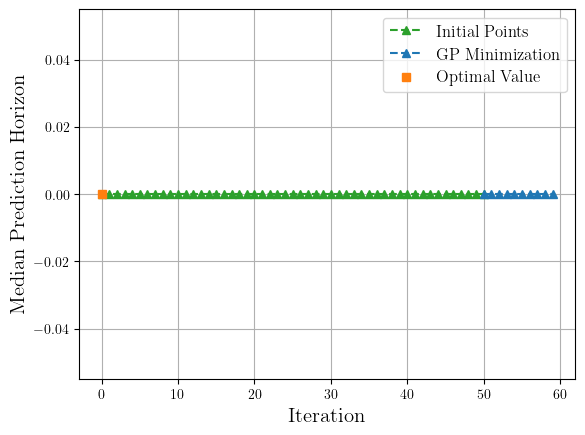

In [49]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

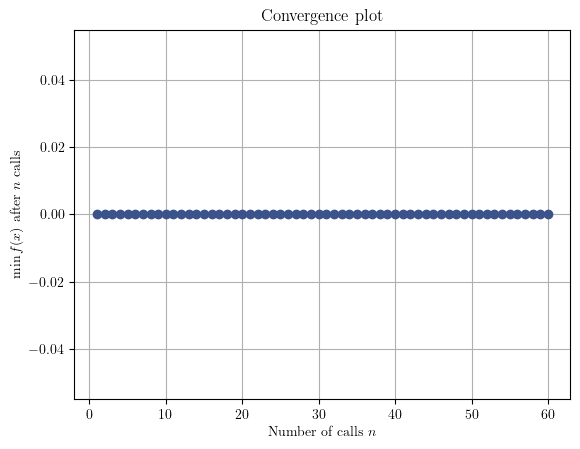

In [50]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [51]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

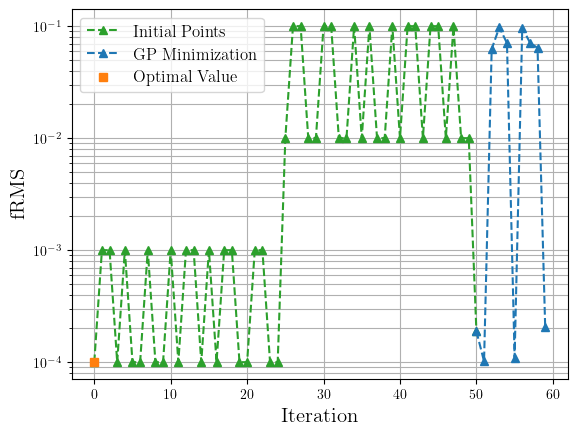

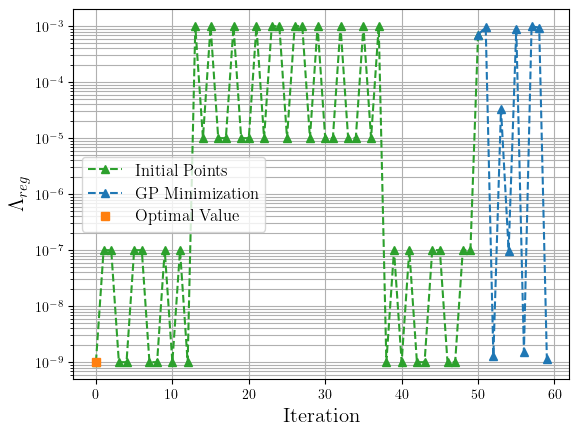

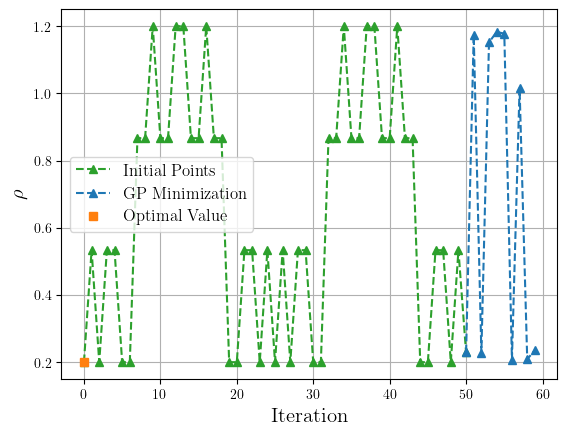

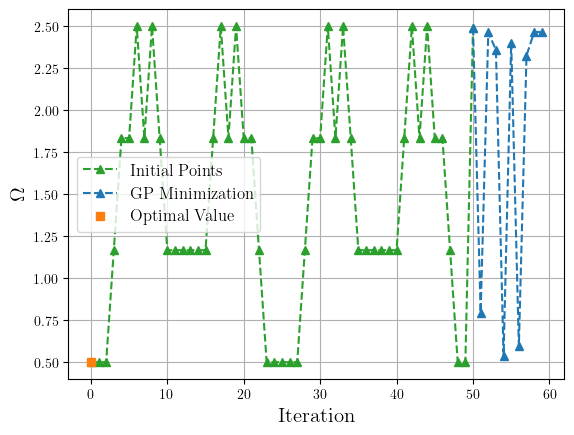

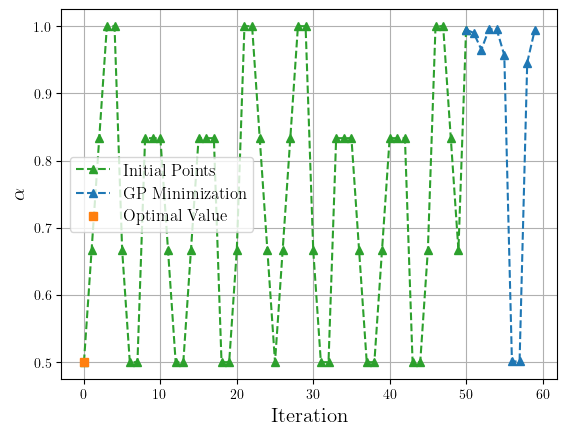

In [52]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append([r'Degree of Connectivity', 'deg_of_connectivity', plt.plot])

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [53]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [54]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/prediction_horizons-testingdata.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rkaushik/Documents/Thesis/MLROM/new_lorenz/ESN_params_Search/params_search_003/tested_ESN/test_ESN_051/prediction_horizons-testingdata.npz'

In [ ]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [ ]:
idx, dir_list[idx[0]]

In [ ]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

In [ ]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation